### TEXT CLASSIFICATION ALGORITHM ON REVIEWS AND THEIR PERFORMANCE EVALUATION

In [1]:
# importing necessary libraries
import os
import pandas as pd

# scraping the customer reviews.
import requests
from bs4 import BeautifulSoup, SoupStrainer

# Pre-processing libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# evaluation strategies
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, RepeatedKFold

import warnings
warnings.filterwarnings("ignore")

# text pre-processing
import nltk

# For displaying the confusion matrix
import seaborn as sn

### TASK 1:

__Select three review categories of your choice. Scrape all reviews for each category and store them as three separate datasets. For each review, you should store the review text and a class label (i.e. whether the review is “positive” or “negative”).__

***CATEGORIES SELECTED: GYM, FASHION, AND HAIR_SALONS***

#### 1.1 SCRAPING THE MAIN CATEGORY LINKS

In [2]:
# Creating a list of selected categories.
main_url='http://mlg.ucd.ie/modules/yalp/'

# To store the main category hyperlinks
categories_url = []

# retrieve the data from the specified base url. 
base_data = requests.get(main_url)

# scrape the contents of the web page
scraper = BeautifulSoup(base_data.content,'html.parser')

# Since the links are represented using the <a> tags, so wherever 'a' tags exists, all the links are stored in links.
links = scraper.find_all('a')

# Selecting only the Gym, Fashion, and Hair and Salons categories.
for link in links:
    # Get the contents of href tags using get() function.
    link = link.get('href')
    
    if 'gym' in link or 'fashion' in link or 'hair' in link:
        # Appending the base url and the extracted link and storing them in the list of categories.
        url = main_url + str(link)
        categories_url.append(url) 
        
print(categories_url)

['http://mlg.ucd.ie/modules/yalp/fashion_list.html', 'http://mlg.ucd.ie/modules/yalp/gym_list.html', 'http://mlg.ucd.ie/modules/yalp/hair_salons_list.html']


#### 1.2 SCRAPING THE SUB CATEGORIES WITHIN THE MAIN CATEGORIES

In [3]:
# To store the final reviews along with the ratings.
category_reviews_ratings = []

# To store the sub links of all the categories.
sub_categories = []

for category in categories_url:
    sub_cat = []
    
    # retrieve the data from the specified base url. 
    base_data = requests.get(category)
    
    # scrape the contents of the web page
    scraper = BeautifulSoup(base_data.content,'html.parser')
    
    # Since the links are represented using the <a> tags, so wherever 'a' tags exists, all the links are stored in links.
    links = scraper.find_all('a')
    
    # Selecting only the Gym, Fashion, and Hair and Salons categories.
    for link in links:
        
        # Get the contents of href tags.
        link = link.get('href')
        
        # Wherever 'index' exists in the link, skipping it.
        if 'index' in link:
            pass
        
        # Store the link of the sub category concatenated with main link.
        else:
            sub_cat.append(main_url+ link)

    sub_categories.append(sub_cat)

#### 1.3 SCRAPING THE REVIEWS OF EVERY SUB CATEGORY OF FASHION, GYMS AND HAIR_SALON 
#### 1.4 REVIEWS ARE RATED POSITIVE OR NEGATIVE BASED ON THEIR RATINGS 

In [4]:
# Fetch the reviews for each sub category of (Fashion, Gym and Hair&Salon)
for i in range(len(sub_categories)):
    curr_category = sub_categories[i]
    # To store the reviews for the selected category.
    reviews_list = []
    # To store the ratings of each reviews for the selected category.
    ratings_list = []
    
    for url in curr_category:
        # retrieve the data from the specified base url. 
        base_data = requests.get(url)
        # scrape the contents of the web page
        scraper = BeautifulSoup(base_data.content,'html.parser')
        #To extract a particular class inside a tag
        reviews = scraper.find_all('p',{"class":"review-text"})
        for review in reviews:
            reviews_list.append(review.text)

        # Ratings exists in alt tag of the img tags.
        ratings = scraper.find_all('img',alt=True)    
        for rating in ratings:
            # Check if rating is less than 3: The review will be Negative.
            if int(rating.get('alt')[0])<=3:
                ratings_list.append('negative')
            
            # Check if rating is greater than 3: The review will be Positive.
            else:
                ratings_list.append('positive')

        # Dictionary of keys Reviews and Ratings
        dict_ = {'Reviews': reviews_list,'Label':ratings_list}
    
    # Converting the Reviews and Ratings to a dataframe and appending to final list
    category_reviews_ratings.append(pd.DataFrame(dict_))

#### 1.5 STORING ALL THE REVIEWS ALONG WITH THEIR RATINGS/TARGET CLASS IN A CSV FILE

In [5]:
# Storing the reviews and their ratings in a comma separated file.
result = pd.concat(category_reviews_ratings)
result.to_csv('./Reviews.csv', index = False)

### TASK 2: 

### **For each of the three category datasets:**

### **a. From the reviews in this category, apply appropriate preprocessing steps to create a numeric representation of the data, suitable for classification.**

In [6]:
# Reading the reviews from the comma separated file using the pandas read_csv().
dframe = pd.read_csv('./Reviews.csv')

# Displaying top 5 reviews.
dframe.head()

,Reviews,Label
0,Looking for the best tactical supplies? Look n...,positive
1,Stood in line like an idiot for 5 minutes to p...,negative
2,Another great store with quality Equipment. Th...,positive
3,The Problem with this store is not that they h...,positive
4,Great place! We went in at almost closing time...,positive


## 2.a PRE-PROCESSING

A data mining technique to transform the raw data scraped from the web sources into cleaner information so as to work efficiently with the clean data is Data Pre Processing.
In order to transform the human language text into machine-readable format, pre-processing is required.

A various number of pre-processing steps are performed on the reviews data so that they can take a form easily used to build the model. Steps are as follows:

1. Data Normalisation
2. Lemmatization
3. Stop Word removal
4. TF-IDF Vectorisation

Data cleaning and transformation are methods used to remove outliers and standardize the data so that they take a form that can be easily used to create a model.

#### 2.a.1. NORMALIZATION

The process to convert all the words in the reviews to same case so as to shrink the vocabulary in size.
It transforms text into a single canonical form that it might not had before.

In [7]:
# For every review present in the dataframe, removing the whitespaces from end and converting them to lowercase.
dframe['Reviews'] = [item.strip().lower() for item in dframe['Reviews']]

# Displaying top 5 reviews after normalization.
dframe['Reviews'].iloc[0:5]

0    looking for the best tactical supplies? look n...
1    stood in line like an idiot for 5 minutes to p...
2    another great store with quality equipment. th...
3    the problem with this store is not that they h...
4    great place! we went in at almost closing time...
Name: Reviews, dtype: object

#### 2.a.2. LEMMATIZATION

A process to group the various inflected terms together so as to analyse them as a single term.
It considers the context while lemmatizing the word by linking the words with similar meaning.

In [8]:
# nltk library provides WordNetLemmatizer() under stem.
lemmatizer = nltk.stem.WordNetLemmatizer()

# Function to lemmatize the text passes through lemmatize() function.
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

In [9]:
# Invoking the lemmatize_text function for every review present in Reviews of the dataframe.
dframe['Reviews'] = dframe.Reviews.apply(lemmatize_text)

# Displaying top 5 reviews after lemmatization.
dframe['Reviews'].iloc[0:5]

0    looking for the best tactical supplies? look n...
1    stood in line like an idiot for 5 minutes to p...
2    another great store with quality equipment. th...
3    the problem with this store is not that they h...
4    great place! we went in at almost closing time...
Name: Reviews, dtype: object

In [10]:
# Displaying the dataframe after two steps of Pre- processing.
dframe.head()

,Reviews,Label
0,looking for the best tactical supplies? look n...,positive
1,stood in line like an idiot for 5 minutes to p...,negative
2,another great store with quality equipment. th...,positive
3,the problem with this store is not that they h...,positive
4,great place! we went in at almost closing time...,positive


#### 2.a.3.STOPWORDS REMOVAL

The terms that does not convey any meaning to the data are referred as Stopwords and they are usually filtered to provide more importance to the actual words.
A list of English words that are to be ignored while pre-processing the data are passed to the TF-IDF vectoriser and all the words in the list will be removed from the reviews.

#### 2.a.4. TF-IDF VECTORIZATION

To depict the importance of a word to a document in a corpus of documents, a numerical statistics called TF-IDF (Term Frequency- Inverse Document Frequency) Vectorisation is used.

It increases proportionally as the word appears in a document and offset by number of documents present in corpus.

In [11]:
# Segregating every category from the original dataframe.
# First 2000 records are the reviews of Fashion category.
fashion = dframe.iloc[0:2000]

# Next 2000 records are the reviews of Gym category.
gyms = dframe.iloc[2000:4000]

# Next 2000 records are the reviews of Hair&Salon category.
hair_salons = dframe.iloc[4000:6000]

category_list = [fashion, gyms, hair_salons]

In [12]:
# For every category selected, reviews are taken in 'reviews' and labels are in 'labels'.
for i in range(len(category_list)):
    # Reviews are stored in 'reviews' for every category.
    reviews = category_list[i]['Reviews']
    # Lables are stored in 'labels' for every category.
    labels = category_list[i]['Label'].tolist()

    # A TF-IDF Vectorizer object is generated to remove the stop words and transform the reviews.
    tf_idf_vec = TfidfVectorizer(stop_words="english",min_df=10)

    reviews_vectorized = tf_idf_vec.fit_transform(reviews)
    
    # Converting the vectorised output to dataframe with column names as the features()
    curr_dframe = pd.DataFrame(reviews_vectorized.todense(), columns = tf_idf_vec.get_feature_names())
    curr_dframe['Label'] = labels
    
    # Counter for number of terms.
    terms = tf_idf_vec.get_feature_names()
    # Displaying the distinct terms in every category.
    if i == 0:
        fashion = curr_dframe
        print("Reviews in {} has {} distinct terms" .format('Fashion',len(terms)))
    elif i == 1:
        gyms = curr_dframe
        print("Reviews in {} has {} distinct terms" .format('Gyms',len(terms)))
    elif i == 2:
        hair_salons = curr_dframe
        print("Reviews in {} has {} distinct terms" .format('Hair&Salon',len(terms)))

Reviews in Fashion has 1464 distinct terms
Reviews in Gyms has 1728 distinct terms
Reviews in Hair&Salon has 1285 distinct terms


### **b. Build a classification model to distinguish between “positive” and “negative” reviews using one of the following classifiers: Naive Bayes, Logistic Regression, Random Forests**

### 2.b.1. CLASSIFICATION MODEL for Fashion Category

Logistic Regression classifier is selected out of all 3 classifier due to its highest accuracy at prediction. 

In [13]:
# Splitting the dataset in training and testing dataset for Fashion category. (All the features except last are used in training and last target is used in test.)

X_fashion_train, X_fashion_test,Y_fashion_train, Y_fashion_test = train_test_split(fashion.iloc[:,:-1], fashion.iloc[:,-1], test_size = 0.3)

# Displaying the shape of each partition so as to check the output of train_test_split().
print("X_fashion_train_shape:{}\nX_fashion_test_shape:{}\nY_fashion_train_shape:{}\nY_fashion_test_shape:{} \n".format(X_fashion_train.shape, X_fashion_test.shape,Y_fashion_train.shape, Y_fashion_test.shape))

# Logistic Regression Classifier.
logreg = LogisticRegression()

# Mapping the training dataset to its test data.
logreg.fit(X_fashion_train, Y_fashion_train)

# Predicting the target for the test dataset for Fashion category.
Y_fashion_pred = logreg.predict(X_fashion_test)

X_fashion_train_shape:(1400, 1464)
X_fashion_test_shape:(600, 1464)
Y_fashion_train_shape:(1400,)
Y_fashion_test_shape:(600,) 



### 2.b.2. CLASSIFICATION MODEL for Gyms Category

In [14]:
# Splitting the dataset in training and testing dataset for Gym category. (All the features except last are used in training and last target is used in test.)
X_gyms_train, X_gyms_test,Y_gyms_train, Y_gyms_test = train_test_split(gyms.iloc[:,:-1], gyms.iloc[:,-1], test_size = 0.3)

# Displaying the shape of each partition so as to check the output of train_test_split().
print("X_gyms_train_shape:{}\nX_gyms_test_shape:{}\nY_gyms_train_shape:{}\nY_gyms_test_shape:{} \n".format(X_gyms_train.shape, X_gyms_test.shape,Y_gyms_train.shape, Y_gyms_test.shape))

# Logistic Regression Classifier.
logreg = LogisticRegression()

# Mapping the training dataset to its test data.
logreg.fit(X_gyms_train, Y_gyms_train)

# Predicting the target for the test dataset of Gym dataset.
Y_gyms_pred = logreg.predict(X_gyms_test)

X_gyms_train_shape:(1400, 1728)
X_gyms_test_shape:(600, 1728)
Y_gyms_train_shape:(1400,)
Y_gyms_test_shape:(600,) 



### 2.b.3.CLASSIFICATION MODEL for Hair_Salons Category

In [15]:
# Splitting the dataset in training and testing dataset for Hair&Salon category. (All the features except last are used in training and last target is used in test.)
X_hair_salons_train, X_hair_salons_test,Y_hair_salons_train, Y_hair_salons_test = train_test_split(hair_salons.iloc[:,:-1], hair_salons.iloc[:,-1], test_size = 0.3)

# Displaying the shape of each partition so as to check the output of train_test_split().
print("X_hair_salons_train_shape:{}\nX_hair_salons_test_shape:{}\nY_hair_salons_train_shape:{}\nY_hair_salons_test_shape:{} \n".format(X_hair_salons_train.shape, X_hair_salons_test.shape,Y_hair_salons_train.shape, Y_hair_salons_test.shape))

# Logistic Regression Classifier.
logreg = LogisticRegression()

# Mapping the training dataset to its test data.
logreg.fit(X_hair_salons_train, Y_hair_salons_train)

# Predicting the target for the test dataset of Hair&Salon dataset.
Y_hair_salons_pred = logreg.predict(X_hair_salons_test)

X_hair_salons_train_shape:(1400, 1285)
X_hair_salons_test_shape:(600, 1285)
Y_hair_salons_train_shape:(1400,)
Y_hair_salons_test_shape:(600,) 



### **c. Test the predictions of the classification model using an appropriate evaluation strategy. Report and discuss the evaluation results in your notebook.**

### 2.c.1 EVALUATING Fashion CATGEORY

TOTAL ACCURACY:86.0% 

REPORT:
              precision    recall  f1-score   support

    negative       0.93      0.72      0.81       245
    positive       0.83      0.96      0.89       355

    accuracy                           0.86       600
   macro avg       0.88      0.84      0.85       600
weighted avg       0.87      0.86      0.86       600



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

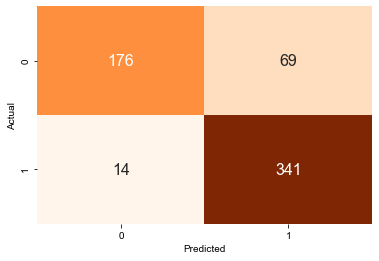

In [16]:
# Evaluating the Fashion category prediction through accuracy score by comparing predicted and actual.

acc = accuracy_score(Y_fashion_pred, Y_fashion_test)
print('TOTAL ACCURACY:{}% \n'.format(round(acc*100),2))

# Displaying the confusion matrix.
matrix = confusion_matrix(Y_fashion_test,Y_fashion_pred)
#print("CONFUSION MATRIX:\n{}\n".format(matrix))

# Printing the confusion report
report = classification_report(Y_fashion_test, Y_fashion_pred)
print("REPORT:\n{}".format(report))

# Representing the confusion matrix
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(matrix, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Oranges')
sn.set(font_scale= 1.5)

# Set the text to display in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# X and Y axis labels.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 2.c.2. CROSS VALIDATION

In [17]:
# 5 fold Cross validation so as to consider every review as a part of test data once and training dataset as k-1(4) times.
acc_scores = cross_val_score(logreg, X_fashion_train, Y_fashion_train, cv=5, scoring="accuracy")

# represent the results as a Pandas Series
labels = [ "Fold %d" % i for i in range(1,len(acc_scores)+1) ]
s_acc = pd.Series(acc_scores, index = labels)
s_acc

Fold 1    0.864286
Fold 2    0.839286
Fold 3    0.892857
Fold 4    0.846429
Fold 5    0.864286
dtype: float64

In [18]:
# Mean accuracy of 5 folds
print("Mean accuracy: %.4f" % s_acc.mean() )

Mean accuracy: 0.8614


### 2.c.3. REPEATED K FOLDS

In [19]:
# Performance is evaluated using the RepeatedKFold.
rkf = RepeatedKFold(n_splits=5, n_repeats=10)

# RepeatedKFold is passed as the parameter cv.
repeated_acc_scores = cross_val_score(logreg, X_fashion_train, Y_fashion_train, cv=rkf, scoring="accuracy")
repeated_acc_scores

array([0.87857143, 0.80714286, 0.88214286, 0.84642857, 0.875     ,
       0.86071429, 0.81071429, 0.86785714, 0.89285714, 0.875     ,
       0.89642857, 0.88928571, 0.88214286, 0.80357143, 0.875     ,
       0.88571429, 0.86785714, 0.89642857, 0.84285714, 0.82857143,
       0.85357143, 0.86428571, 0.88571429, 0.83928571, 0.88928571,
       0.81428571, 0.81428571, 0.85714286, 0.90357143, 0.91071429,
       0.85357143, 0.875     , 0.86785714, 0.86428571, 0.85      ,
       0.87857143, 0.83571429, 0.875     , 0.87857143, 0.86428571,
       0.875     , 0.85357143, 0.89285714, 0.83928571, 0.86071429,
       0.88928571, 0.83214286, 0.84642857, 0.86071429, 0.88571429])

In [20]:
# Converting the results to Pandas Series.
s_racc = pd.Series(repeated_acc_scores)
s_racc.head(20)

0     0.878571
1     0.807143
2     0.882143
3     0.846429
4     0.875000
5     0.860714
6     0.810714
7     0.867857
8     0.892857
9     0.875000
10    0.896429
11    0.889286
12    0.882143
13    0.803571
14    0.875000
15    0.885714
16    0.867857
17    0.896429
18    0.842857
19    0.828571
dtype: float64

In [21]:
# Calculating average accuracy and standard deviation
print("Overall mean accuracy: %.4f" % s_racc.mean() )
print("Overall standard deviation in accuracy: %.4f" % s_racc.std() )

Overall mean accuracy: 0.8635
Overall standard deviation in accuracy: 0.0262


### 2.c.4. MISCLASSIFIED REVIEWS OF FASHION CATEGORY

In [22]:
# Mis classified reviews of Fashion Category.
num_examples = 0 
for i, predicted_class in enumerate(Y_fashion_pred):
    
    # If predicted is positive and actual is negative or vice-versa, it is misclassified.
    if Y_fashion_test.iloc[i] == 'positive' and predicted_class == 'negative' or Y_fashion_test.iloc[i] == 'negative' and predicted_class == 'positive':
        ind = Y_fashion_test.index[i]
        print( "%s: %s" % ( ind,curr_dframe.loc[ind]["Label"] ) )
        num_examples += 1
    if num_examples == 5:
        break

1946: positive
1454: negative
437: positive
1373: positive
587: positive


### 2.c.5. EVALUATING Gyms CATEGORY

TOTAL ACCURACY:87.83333333333333% 

REPORT:
              precision    recall  f1-score   support

    negative       0.95      0.68      0.79       205
    positive       0.86      0.98      0.91       395

    accuracy                           0.88       600
   macro avg       0.90      0.83      0.85       600
weighted avg       0.89      0.88      0.87       600



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

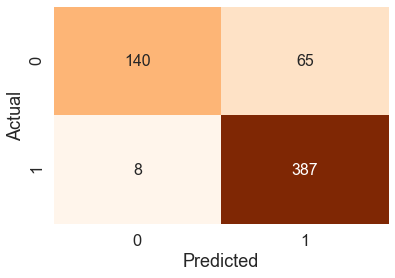

In [23]:
# Evaluating the Gym category prediction through accuracy score by comparing predicted and actual.

acc = accuracy_score(Y_gyms_pred, Y_gyms_test)
print('TOTAL ACCURACY:{}% \n'.format(acc*100))

# Displaying the confusion matrix.
matrix = confusion_matrix(Y_gyms_test,Y_gyms_pred)
#print("CONFUSION MATRIX:\n{}\n".format(matrix))

# Printing the confusion report
report = classification_report(Y_gyms_test, Y_gyms_pred)
print("REPORT:\n{}".format(report))

# Representing the confusion matrix
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(matrix, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Oranges')
sn.set(font_scale= 1.5)

# Set the text to display in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# X and Y axis labels.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### 2.c.6. CROSS VALIDATION

In [24]:
# 5 fold Cross validation so as to consider every review of Gyms dataset as a part of test data once and training dataset as k-1(4) times.
acc_scores = cross_val_score(logreg, X_gyms_train, Y_gyms_train, cv=5, scoring="accuracy")

# represent the results as a Pandas Series
labels = [ "Fold %d" % i for i in range(1,len(acc_scores)+1) ]
s_acc = pd.Series(acc_scores, index = labels)
s_acc

Fold 1    0.857651
Fold 2    0.896429
Fold 3    0.889286
Fold 4    0.871429
Fold 5    0.878136
dtype: float64

In [25]:
# Mean accuracy of 5 folds
print("Mean accuracy: %.4f" % s_acc.mean() )

Mean accuracy: 0.8786


### 2.c.7. REPEATED K FOLDS

In [26]:
# Performance is evaluated using the RepeatedKFold.
rkf = RepeatedKFold(n_splits=5, n_repeats=10)

# RepeatedKFold is passed as the parameter cv.
repeated_acc_scores = cross_val_score(logreg, X_fashion_train, Y_fashion_train, cv=rkf, scoring="accuracy")
repeated_acc_scores

array([0.88214286, 0.86785714, 0.88214286, 0.86071429, 0.83928571,
       0.83214286, 0.86071429, 0.89285714, 0.88571429, 0.86071429,
       0.86428571, 0.88214286, 0.85714286, 0.86785714, 0.85357143,
       0.85357143, 0.82142857, 0.88214286, 0.83928571, 0.88214286,
       0.85      , 0.83928571, 0.87857143, 0.88928571, 0.86071429,
       0.84285714, 0.85357143, 0.875     , 0.87857143, 0.85      ,
       0.89642857, 0.86785714, 0.82857143, 0.87142857, 0.86785714,
       0.90357143, 0.84642857, 0.87142857, 0.85714286, 0.85714286,
       0.875     , 0.83214286, 0.89285714, 0.89285714, 0.825     ,
       0.86428571, 0.88571429, 0.86785714, 0.85      , 0.86428571])

In [27]:
# Converting the results to Pandas Series.
s_racc = pd.Series(repeated_acc_scores)
s_racc.head(20)

0     0.882143
1     0.867857
2     0.882143
3     0.860714
4     0.839286
5     0.832143
6     0.860714
7     0.892857
8     0.885714
9     0.860714
10    0.864286
11    0.882143
12    0.857143
13    0.867857
14    0.853571
15    0.853571
16    0.821429
17    0.882143
18    0.839286
19    0.882143
dtype: float64

In [28]:
# Calculating average accuracy and standard deviation
print("Overall mean accuracy: %.4f" % s_racc.mean() )
print("Overall standard deviation in accuracy: %.4f" % s_racc.std() )

Overall mean accuracy: 0.8641
Overall standard deviation in accuracy: 0.0199


### 2.c.8. MISCLASSIFIED REVIEWS OF GYM CATEGORY

In [29]:
# Mis classified reviews of Gym Category.
num_examples = 0 
for i, predicted_class in enumerate(Y_gyms_pred):
    
    # If predicted is positive and actual is negative or vice-versa, it is misclassified.
    if Y_gyms_test.iloc[i] == 'positive' and predicted_class == 'negative' or Y_gyms_test.iloc[i] == 'negative' and predicted_class == 'positive':
        ind = Y_gyms_test.index[i]
        print( "%s: %s" % ( ind,curr_dframe.loc[ind]["Label"] ) )
        num_examples += 1
    if num_examples == 5:
        break

1362: positive
782: positive
17: positive
1550: positive
1428: positive


### 2.c.9. EVALUATING Hair_Salons CATEGORY

TOTAL ACCURACY:91.33333333333333 

REPORT:
              precision    recall  f1-score   support

    negative       0.97      0.57      0.72       117
    positive       0.91      1.00      0.95       483

    accuracy                           0.91       600
   macro avg       0.94      0.78      0.83       600
weighted avg       0.92      0.91      0.90       600



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

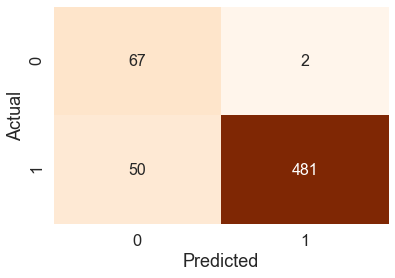

In [30]:
# Evaluating the Hair&Salon category prediction through accuracy score by comparing predicted and actual.
acc = accuracy_score(Y_hair_salons_pred, Y_hair_salons_test)
print('TOTAL ACCURACY:{} \n'.format(acc*100))

# Displaying the confusion matrix.
matrix = confusion_matrix(Y_hair_salons_pred,Y_hair_salons_test)
#print("CONFUSION MATRIX:\n{}\n".format(matrix))

# Printing the confusion report
report = classification_report(Y_hair_salons_test, Y_hair_salons_pred)
print("REPORT:\n{}".format(report))

# Representing the confusion matrix
fig, ax = plt.subplots(figsize=(6,4))
sn.heatmap(matrix, annot=True, cbar = False, fmt = 'd', annot_kws= {'size':16}, cmap= 'Oranges')
sn.set(font_scale= 1.5)

# Set the text to display in middle.
bottom,top = ax.get_ylim()
ax.set_ylim(bottom +0.5, top - 0.5)

# X and Y axis labels.
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


### 2.c.10. CROSS VALIDATION

In [31]:
# 5 fold Cross validation so as to consider every review of Hair_Salon dataset as a part of test data once and training dataset as k-1(4) times.
acc_scores = cross_val_score(logreg, X_hair_salons_train, Y_hair_salons_train, cv=5, scoring="accuracy")

# represent the results as a Pandas Series
labels = [ "Fold %d" % i for i in range(1,len(acc_scores)+1) ]
s_acc = pd.Series(acc_scores, index = labels)
s_acc

Fold 1    0.871429
Fold 2    0.871429
Fold 3    0.864286
Fold 4    0.878571
Fold 5    0.878571
dtype: float64

In [32]:
# Mean accuracy of 5 folds
print("Mean accuracy: %.4f" % s_acc.mean() )

Mean accuracy: 0.8729


### 2.c.11. REPEATED K FOLDS

In [33]:
# Performance is evaluated using the RepeatedKFold.
rkf = RepeatedKFold(n_splits=5, n_repeats=10)

# RepeatedKFold is passed as the parameter cv.
repeated_acc_scores = cross_val_score(logreg, X_fashion_train, Y_fashion_train, cv=rkf, scoring="accuracy")
repeated_acc_scores

array([0.825     , 0.89285714, 0.85357143, 0.86785714, 0.89285714,
       0.87142857, 0.87857143, 0.86428571, 0.81428571, 0.88214286,
       0.89285714, 0.85      , 0.84642857, 0.86785714, 0.88928571,
       0.83928571, 0.82142857, 0.86428571, 0.86428571, 0.90357143,
       0.86785714, 0.875     , 0.88571429, 0.825     , 0.88214286,
       0.88571429, 0.87857143, 0.82857143, 0.86071429, 0.85714286,
       0.90357143, 0.86071429, 0.86785714, 0.83571429, 0.85      ,
       0.84642857, 0.87857143, 0.86785714, 0.825     , 0.87142857,
       0.83928571, 0.83928571, 0.86428571, 0.85357143, 0.87857143,
       0.87857143, 0.83928571, 0.87142857, 0.88571429, 0.83571429])

In [34]:
# Converting the results to Pandas Series.
s_racc = pd.Series(repeated_acc_scores)
s_racc.head(20)

0     0.825000
1     0.892857
2     0.853571
3     0.867857
4     0.892857
5     0.871429
6     0.878571
7     0.864286
8     0.814286
9     0.882143
10    0.892857
11    0.850000
12    0.846429
13    0.867857
14    0.889286
15    0.839286
16    0.821429
17    0.864286
18    0.864286
19    0.903571
dtype: float64

In [35]:
# Calculating average accuracy and standard deviation
print("Overall mean accuracy: %.4f" % s_racc.mean() )
print("Overall standard deviation in accuracy: %.4f" % s_racc.std() )

Overall mean accuracy: 0.8624
Overall standard deviation in accuracy: 0.0226


### 2.c.12. MISCLASSIFIED REVIEWS OF HAIR_SALON CATEGORY

In [36]:
# Mis classified reviews of Hair&Salon Category.
num_examples = 0 
for i, predicted_class in enumerate(Y_hair_salons_pred):
    
    # If predicted is positive and actual is negative or vice-versa, it is misclassified.
    if Y_hair_salons_test.iloc[i] == 'positive' and predicted_class == 'negative' or Y_hair_salons_test.iloc[i] == 'negative' and predicted_class == 'positive':
        ind = Y_hair_salons_test.index[i]
        print( "%s: %s" % ( ind,curr_dframe.loc[ind]["Label"] ) )
        num_examples += 1
    if num_examples == 5:
        break

115: negative
1152: negative
1922: negative
1544: negative
1382: negative


### TASK 3: 

### **Evaluate the performance of each of your three classification models when applied to data from the other two selected categories. That is, for the selected categories (A,B,C), run the experiments:**

Reviews and Labels from collective reviews irrwespective of the category are assigned to dframe_reviews and dframe_labels.

All the reviews are pre-processed using the TF-IDF Vectorizer.

In [37]:
# Collectively converting the reviews of all the 3 selected categories to TF-IDF vectors.
# dframe_reviews stores all the Reviews.
dframe_reviews = dframe['Reviews']

# dframe_labels stores all the Label.
dframe_labels = dframe['Label'].tolist()

# A TF-IDF Vectorizer object is generated to remove the stop words and transform the reviews.
tfidf_vec = TfidfVectorizer(stop_words="english",min_df=10)

dframe_reviews_vectorized = tfidf_vec.fit_transform(dframe_reviews)

# Converting the vectorised output to dataframe with column names as the features()
curr_dframe = pd.DataFrame(dframe_reviews_vectorized.todense(), columns = tfidf_vec.get_feature_names())

# Setting the Target column in the dataframe with labels
curr_dframe['Label'] = dframe_labels

# Displaying the shape of dataframe.
curr_dframe.shape

(6000, 3387)

Dividing the data into 3 categories.

In [38]:
# Segregating the data into 3 categories of fashion, gym and hair&salon.

# Every category consists of 2000 reviews. So, fetching the first 2000 reviews in fashion dataframe.
fashion_dframe = curr_dframe.iloc[0:2000,:]
fashion_dframe['Label'] = dframe_labels[:2000]

# The next 2000 reviews are extracted in gyms dataframe.
gyms_dframe = curr_dframe.iloc[2000:4000,:]
gyms_dframe['Label'] = dframe_labels[2000:4000]

# The last 2000 reviews are extracted in hair_salon dataframe.
hair_salons_dframe = curr_dframe.iloc[4000:6000,:]
hair_salons_dframe['Label'] = dframe_labels[4000:]

In [39]:
# Displaying the shape of every dataframe so as to ensure number of reviews within them.

print('Fashion dataframe shape:',fashion_dframe.shape)
print('Gyms dataframe shape:',gyms_dframe.shape)
print('Hair and Salons dataframe shape:',hair_salons_dframe.shape)

Fashion dataframe shape: (2000, 3387)
Gyms dataframe shape: (2000, 3387)
Hair and Salons dataframe shape: (2000, 3387)


### **a. Train a classification model on the data from “Category A”. Evaluate its performance on data from “Category B” and data from “Category C”.**

In [40]:
# In order to train the model on the Category A which is Fashion in this case, considering the fashion dataframe as the training dataset
# All the attributes are considered as X_train data except the target value which is taken into account as Y_train data.
X_fashion_train = fashion_dframe.iloc[:,:-1]
Y_fashion_train = fashion_dframe['Label']

# Building a Logistic Regression model.
logReg = LogisticRegression()
# Training the model on fashion data.
logReg.fit(X_fashion_train, Y_fashion_train)

# In order to evaluate the performance of the model on the Category B and category C, taking category B as gyms here.
# The Gyms dataframe is considered as the Test Dataset.
# All the features except label are considered in X and the target is taken into Y.
X_gyms_test = gyms_dframe.iloc[:,:-1]
Y_gyms_test = gyms_dframe['Label']

# Predicting the ratings of gyms test data using the logistic regression model trained on fashion data.
Y_gyms_pred = logReg.predict(X_gyms_test)

# Evaluating the performance of the trained logistic regression model on gyms data.
acc_score = accuracy_score(Y_gyms_pred, Y_gyms_test)
print('Accuracy when Training on "{}" and Testing on "{}"= {}%'.format('Fashion','Gyms',round(acc_score*100),2))

# In order to evaluate the performance of the model on the Category B and category C, considering category C as hair_salon.
# The Hair_Salon dataframe is considered as the Test Dataset.
# All the features except label are considered in X and the target is taken into Y.
X_hair_salons_test = hair_salons_dframe.iloc[:,:-1]
Y_hair_salons_test = hair_salons_dframe['Label']

# Predicting the ratings of hair_salon test data using the logistic regression model trained on fashion data.
Y_hair_salons_pred = logReg.predict(X_hair_salons_test)

# Evaluating the performance of the trained logistic regression model on hair_salon data.
acc_score = accuracy_score(Y_hair_salons_test, Y_hair_salons_pred)
print('Accuracy when Training on "{}" and Testing on "{}"= {}%'.format('Fashion','Hair and Salon',round(acc_score*100),2))

Accuracy when Training on "Fashion" and Testing on "Gyms"= 87.0%
Accuracy when Training on "Fashion" and Testing on "Hair and Salon"= 92.0%


### **b. Train a classification model on the data from “Category B”. Evaluate its performance on data from “Category A” and data from “Category C”.**

In [41]:
# In order to train the model on the Category B which is Gyms in this case, considering the gyms dataframe as the training dataset.
# All the attributes are considered as X_train data except the target value which is taken into account as Y_train data.
X_gyms_train = gyms_dframe.iloc[:,:-1]
Y_gyms_train = gyms_dframe['Label']

# Building a Logistic Regression model.
logReg = LogisticRegression()
# Training the model on gyms data.
logReg.fit(X_gyms_train, Y_gyms_train)

# In order to evaluate the performance of the model on the Category A and category C, taking category A as fashion here.
# The Fashion dataframe is considered as the Test Dataset.
# All the features except label are considered in X and the target is taken into Y.
X_fashion_test = fashion_dframe.iloc[:,:-1]
Y_fashion_test = fashion_dframe['Label']

# Predicting the ratings of fashion test data using the logistic regression model trained on gyms data.
Y_fashion_pred = logReg.predict(X_fashion_test)

# Evaluating the performance of the trained logistic regression model on fashion data.
acc_score = accuracy_score(Y_fashion_pred, Y_fashion_test)
print('Accuracy when Training on "{}" and Testing on "{}"= {}%'.format('Gyms','Fashion',acc_score*100))

# In order to evaluate the performance of the model on the Category B and category C, considering category C as hair_salon.
# The Hair_Salon dataframe is considered as the Test Dataset.
# All the features except label are considered in X and the target is taken into Y.
X_hair_salons_test = hair_salons_dframe.iloc[:,:-1]
Y_hair_salons_test = hair_salons_dframe['Label']

# Predicting the ratings of hair_salon test data using the logistic regression model trained on gyms data.
Y_hair_salons_pred = logReg.predict(X_hair_salons_test)

# Evaluating the performance of the trained logistic regression model on hair_salon data.
acc_score = accuracy_score(Y_hair_salons_test, Y_hair_salons_pred)
print('Accuracy when Training on "{}" and Testing on "{}"= {}%'.format('Gyms','Hair and Salon',acc_score*100))

Accuracy when Training on "Gyms" and Testing on "Fashion"= 86.25%
Accuracy when Training on "Gyms" and Testing on "Hair and Salon"= 92.25%


### **c. Train a classification model on the data from “Category C”. Evaluate its performance on data from “Category A” and data from “Category B”.**

In [42]:
# In order to train the model on the Category C which is Hair_Salon in this case, considering the Hair_Salon dataframe as the training dataset.
# All the attributes are considered as X_train data except the target value which is taken into account as Y_train data.
X_hair_salons_train = hair_salons_dframe.iloc[:,:-1]
Y_hair_salons_train = hair_salons_dframe['Label']

# Building a Logistic Regression model.
logReg = LogisticRegression()
# Training the model on gyms data.
logReg.fit(X_hair_salons_train, Y_hair_salons_train)

# In order to evaluate the performance of the model on the Category A and category B, taking category A as fashion here.
# The Fashion dataframe is considered as the Test Dataset.
# All the features except label are considered in X and the target is taken into Y.
X_fashion_test = fashion_dframe.iloc[:,:-1]
Y_fashion_test = fashion_dframe['Label']

# Predicting the ratings of fashion test data using the logistic regression model trained on hair_salon data.
Y_fashion_pred = logReg.predict(X_fashion_test)

# Evaluating the performance of the trained logistic regression model on fashion data.
acc_score = accuracy_score(Y_fashion_pred, Y_fashion_test)
print('Accuracy when Training on "{}" and Testing on "{}"= {}%'.format('Hair n Salons','Fashion',acc_score*100))

# In order to evaluate the performance of the model on the Category A and category B, considering category B as gyms.
# The gyms dataframe is considered as the Test Dataset.
# All the features except label are considered in X and the target is taken into Y.
X_gyms_test = gyms_dframe.iloc[:,:-1]
Y_gyms_test = gyms_dframe['Label']

# Predicting the ratings of gyms test data using the logistic regression model trained on hair_salon dataset.
Y_gyms_pred = logReg.predict(X_gyms_test)

# Evaluating the performance of the trained logistic regression model on gyms data.
acc_score = accuracy_score(Y_gyms_pred, Y_gyms_test)
print('Accuracy when Training on "{}" and Testing on "{}"= {}%'.format('Hair and Salon', 'Gyms', acc_score*100))

Accuracy when Training on "Hair n Salons" and Testing on "Fashion"= 78.4%
Accuracy when Training on "Hair and Salon" and Testing on "Gyms"= 77.4%


### CONCLUSION

To begin with,
- Large amount of reviews from Fashion, Gyms and Hair_salon are scraped with the help of BeautifulSoup.

- Initially, all the main links are fetched using the fetch_all functionality of the scraper and out of which the 3 selected category links are stored in a list for further reference.

- For every main category, requests.get() function fetches the links through 'a' tag. Further contents of href tags are fetched.

- Further for every category, all the contents are scraped using the BeautifulSoup() and reviews are extracted from it using the 'p' tags. 

- Based on the number of ratings, target class is decided for every review and every review along with its target class is saved in a comma separated file.

- Further a number of pre-processing steps are performed over text reviews:
	1. Data Normalization in order to transform the text into a single canonical form.
	2. Lemmatization in order to group the various inflected terms together so as to analyse them as a single term considering the context.
	3. Stopwords removal so as to provide more importance to the actual words instead of low meaning conveying terms.
	4. Term Frequency Inverse Document Vectorisation.
	
- Following which Logistic Regression model is built for every category (Fashion, Gyms, Hair_Salon) and evaluating the performance of each category through Confusion matrix and depicting the misclassified reviews.

- Next, Training the model with every category acting as training dataset and testing its performance over other two categories is evaluated.

- Accuracy while model trained on Fashion dataset and Gyms dataset and testing on Gyms and Hair_Salon dataset comes to be the maximum counting to approximately 87 % and 92.5 %.

- Logistic Regression classification model proves to be most efficient among the three classification models.

- The performance of every model is evaluated using a number of techniques:
    1. Confusion Matrix
    2. K Fold Cross Validation
    3. Repeated Fold Cross Validation
    4. Misclassifications
